In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt 

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer


from textblob import TextBlob
from wordcloud import WordCloud

import nltk
from nltk.probability import FreqDist

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [2]:
data = pd.read_csv("data/1600000.processed.noemoticon.csv", encoding='latin-1')
# o.decode('latin-1').encode("utf-8")

In [4]:
print(data.head())

   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                                                                   
2    my whole body feels itchy and like its on fire                                                                    
3  @nationwideclass no, it's not behaving at all....           

In [5]:
new_data = data.iloc[:, [0,5]]

print(new_data.head())

   0  \
0  0   
1  0   
2  0   
3  0   
4  0   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                                                                   
2    my whole body feels itchy and like its on fire                                                                    
3  @nationwideclass no, it's not behaving at all....                                                                   
4                      @Kwesidei not the whole crew                                                                    


In [7]:
def clean_tweet(tweet):
    
    excluded_punct = [".", ",", ":", "^", ";", "-"]
    
    tweet_list = tweet.split()
    clean_tokens = [re.sub('@[\w]+','',t) for t in tweet_list if re.match(r'[^\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_url = re.sub(r'http\S+', '', clean_s)
    
    clean_punctuation = re.sub('(?<! )(?=[.,#!?()])|(?<=[.,#!?()])(?! )', ' ', clean_url)
    clean_mess = [word.lower() for word in clean_punctuation.split() if word.lower() not in stopwords.words('english') and word not in  excluded_punct]
    
    clean_apos = [item.replace("'", "") for item in clean_mess]
    
    return [item.replace("\"", "") for item in clean_apos]

cell = 0

print(new_data.iloc[cell, 1])
print("\n--------------\n")
print(clean_tweet(new_data.iloc[cell, 1]))

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

--------------

['upset', 'cant', 'update', 'facebook', 'texting', 'might', 'cry', 'result', 'school', 'today', 'also', 'blah', '!']


In [8]:
def normalization(tweet_list):
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet_list:
        normalized_text = lem.lemmatize(word,'v')
        normalized_tweet.append(normalized_text)
    return normalized_tweet

print(normalization(new_data.iloc[1,1].split()))

['@Kenichan', 'I', 'dive', 'many', 'time', 'for', 'the', 'ball.', 'Managed', 'to', 'save', '50%', 'The', 'rest', 'go', 'out', 'of', 'bound']


In [44]:
def delete_long_words(vocabulary):
    new_vocab = []
    for i in range(len(vocabulary)):
        if len(vocabulary[i]) <= 15 and len(vocabulary[i]) > 0:
            new_vocab.append(vocabulary[i])
            
    return new_vocab

In [45]:
def text_processing(tweet):
    return delete_long_words(normalization(clean_tweet(tweet)))

print(text_processing(new_data.iloc[1, 1]))

['dive', 'many', 'time', 'ball', 'manage', 'save', 'rest', 'go', 'bound']


### Create Bag Of Words

In [46]:
processed_sentence = new_data.iloc[:, 1].apply(text_processing).to_list()

vocabulary = [inner for outer in processed_sentence for inner in outer]

In [47]:
print(vocabulary[:10])

['upset', 'cant', 'update', 'facebook', 'texting', 'might', 'cry', 'result', 'school', 'today']


In [48]:
freq_dist = FreqDist(vocabulary)
freq_dist.most_common(10)

[('!', 11017),
 ('?', 3036),
 ('get', 2229),
 ('im', 2156),
 ('go', 2037),
 ('work', 1413),
 ('good', 1228),
 ('day', 1175),
 ('today', 1002),
 ('like', 949)]

In [49]:
FreqDist(len(w) for w in vocabulary).most_common()

[(4, 41984),
 (5, 26812),
 (3, 21824),
 (1, 17148),
 (6, 15804),
 (7, 10914),
 (2, 8106),
 (8, 6142),
 (9, 3947),
 (10, 2167),
 (11, 1005),
 (12, 551),
 (13, 342),
 (14, 146),
 (15, 133)]

### Model

In [50]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [51]:
msg_train, msg_test, label_train, label_test = train_test_split(new_data.iloc[:, 1], new_data.iloc[:, 0], test_size=0.2)
pipeline.fit(msg_train,label_train)
predictions = pipeline.predict(msg_test)
print(classification_report(predictions,label_test))
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))

# 0.74275

              precision    recall  f1-score   support

           0       0.78      0.71      0.74      2141
           4       0.70      0.77      0.73      1859

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000

[[1528  613]
 [ 434 1425]]
0.73825


In [52]:
unique, counts = np.unique(predictions, return_counts=True)

print(np.asarray((unique, counts)).T)

[[   0 2141]
 [   4 1859]]


### Bi-grams

In [58]:
tokens = [inner for outer in processed_sentence for inner in outer]
def get_bigrams(tokens):
    return [(tokens[i],tokens[i+1]) for i in range(0,len(tokens)-1)]
 
bigrams_vocab = get_bigrams(tokens)

In [59]:
freq_dist = FreqDist(bigrams_vocab)
freq_dist.most_common(15)

[(('!', '!'), 3197),
 (('?', '?'), 525),
 (('good', 'morning'), 266),
 (('!', 'im'), 263),
 (('?', '!'), 199),
 (('last', 'night'), 197),
 (('cant', 'wait'), 151),
 (('!', 'thank'), 146),
 (('day', '!'), 144),
 (('thank', '!'), 142),
 (('!', 'get'), 129),
 (('!', 'love'), 128),
 (('feel', 'like'), 125),
 (('!', 'good'), 122),
 (('today', '!'), 119)]

### Subjectivity and Objectivity

In [53]:
# how subjective or opinionated the text is; a score of 0 is fact, and a score of +1 is very much an opinion
def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

# how positive or negative the text is;
def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity


sentences_info = {'Subjectivity':[], 'Polarity':[], 'Sentiment': []} 

concat_pro_words = new_data.iloc[:, 1].apply(text_processing).str.join(" ").to_list()

for i in range(len(concat_pro_words)):
    sentiment = getPolarity(concat_pro_words[i])
    sentences_info['Subjectivity'].append(getSubjectivity(concat_pro_words[i]))
    sentences_info['Polarity'].append(sentiment)
    
    if sentiment == 0:
        sentences_info['Sentiment'].append('Neutral')
    elif sentiment > 0:
        sentences_info['Sentiment'].append('Positive')
    else:
        sentences_info['Sentiment'].append('Negative')

    
sentences_info = pd.DataFrame(sentences_info) 


In [54]:
print(sentences_info.iloc[:5, ])

   Subjectivity  Polarity Sentiment
0           0.0     0.000   Neutral
1           0.5     0.500  Positive
2           0.4     0.200  Positive
3           1.0    -0.625  Negative
4           0.4     0.200  Positive


In [55]:
print(new_data.iloc[:, 0].value_counts())
print("\n-----------\n")
print(sentences_info.iloc[:, 2].value_counts())


4    10001
0     9998
Name: 0, dtype: int64

-----------

Positive    8243
Neutral     7949
Negative    3807
Name: Sentiment, dtype: int64


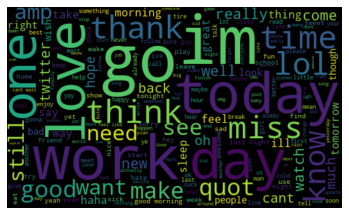

In [56]:
allWords = ' '.join([twts for twts in concat_pro_words])
wordCloud = WordCloud(width=500, height=300, random_state=42, max_font_size=100).generate(allWords)


plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()